In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
train_num = pd.read_csv("train.csv")
test_num = pd.read_csv("test.csv")

In [3]:
# train_num.shape
# test_num.shape
train_data = shuffle(train_num.values)
train_data.shape
Y_train = train_data[:,:1]
X = train_data[:,1:]/255.0
test = test_num/255.0

In [4]:
X_train = X.reshape(-1,28,28,1)
test = np.asarray(test).reshape(-1,28,28,1)

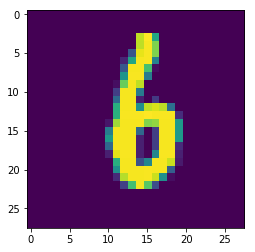

In [5]:
g = plt.imshow(X_train[0][:,:,0])

In [6]:
Y = np.eye(10)[Y_train.reshape(-1)]

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y, test_size = 0.1, random_state=2)

In [8]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(37800, 28, 28, 1)
(37800, 10)
(4200, 28, 28, 1)
(4200, 10)


In [9]:
n_classes = 10
batch_size = 100
x = tf.placeholder('float')
y = tf.placeholder('float')
b=[]
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def maxpool2d(x):
    #                        size of window         movement of window
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')



def convolutional_neural_network(x):
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,1,32])),
               'W_conv2':tf.Variable(tf.random_normal([5,5,32,64])),
               'W_fc':tf.Variable(tf.random_normal([7*7*64,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    conv1 = tf.nn.relu(conv2d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool2d(conv1)
    
    conv2 = tf.nn.relu(conv2d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool2d(conv2)

    fc = tf.reshape(conv2,[-1, 7*7*64])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

def next_batch(index ,data ,labels):
    
    data = data[index*batch_size:(index+1)*batch_size]
    labels = labels[index*batch_size:(index+1)*batch_size]
    
    return np.asarray(data), np.asarray(labels)


def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    saver = tf.train.Saver()
    hm_epochs = 15
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for index in range(int(X_train.shape[0]/batch_size)):
                epoch_x, epoch_y = next_batch(index ,X_train ,Y_train)
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c

            print('Epoch', epoch, 'completed out of',hm_epochs,'loss:',epoch_loss)

        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:',accuracy.eval({x:X_val, y:Y_val}))

        #     classification = sess.run(prediction,feed_dict={x: test[0:1000]})
        #     b = np.argmax(classification,axis=1)
        for i in range(int(test.shape[0]/1000)):
            classification = sess.run(prediction,feed_dict={x: test[i*1000:(i+1)*1000]})
            b.append(np.argmax(classification,axis=-1).tolist())
train_neural_network(x)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0 completed out of 15 loss: 1310010.85028
Epoch 1 completed out of 15 loss: 277503.856339
Epoch 2 completed out of 15 loss: 159729.642095
Epoch 3 completed out of 15 loss: 120414.387168
Epoch 4 completed out of 15 loss: 89034.094106
Epoch 5 completed out of 15 loss: 61517.219072
Epoch 6 completed out of 15 loss: 43501.249602
Epoch 7 completed out of 15 loss: 33602.1711966
Epoch 8 completed out of 15 loss: 25941.5522407
Epoch 9 completed out of 15 loss: 22514.330276
Epoch 10 completed out of 15 loss: 17889.94259
Epoch 11 completed out of 15 loss: 14387.1689717
Epoch 12 completed out of 15 loss: 14768.078845
Epoch 13 completed out of 15 loss: 12651.0258412
Epoch 14 completed out of 15 loss: 10993.0341155
Accuracy: 0.977857


In [10]:
lo = np.array(b)
lo = lo.flatten()
results = pd.Series(lo,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission2.csv",index=False)